# GPU-Accelerated Curve Fitting with Theseus
Theseus is used to provide second-order nonlinear optimizers for efficient and high-throughput curve fitting.

In [2]:
import numpy as np
import h5py
from theseusqfls import genplanck, visualization
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import filedialog

Opens dialog to select photometrically calibrated hyperspectral photoluminescence data file.

In [3]:
root = tk.Tk()
root.withdraw()

file_path = filedialog.askopenfilename()

Individually fits nine selected pixels to provide guesses used to initialize fitting in Theseus

In [4]:
exp_energy, exp_pl = genplanck.import_hyperspectral(file_path)
exp_energy_crop, exp_pl_crop = genplanck.crop_data(exp_energy, exp_pl)
init_guesses = [1.2, 0.025, 1.5, 1.7]
points = [256, 512, 768]
guesses = np.zeros((4, len(points), len(points)))
for i in range(len(points)):
    for j in range(len(points)):
        guesses[:, i, j], __ = curve_fit(genplanck.gen_planck, exp_energy_crop, exp_pl_crop[:, i, j].squeeze(), p0=init_guesses)
guesses = list(np.mean(guesses, axis=(1, 2)))

C:\Users\cbc37\Desktop\theseusqfls\theseusqfls\genplanck.py:104: RuntimeWarning: invalid value encountered in sqrt
  part3 = (1 - math.e ** (-40 * np.sqrt(gamma) * eval_interp((energy - bandgap) / gamma, theta)))


Plots spatially averaged photoluminescence spectrum and compares to simulated data generated from guess parameters above

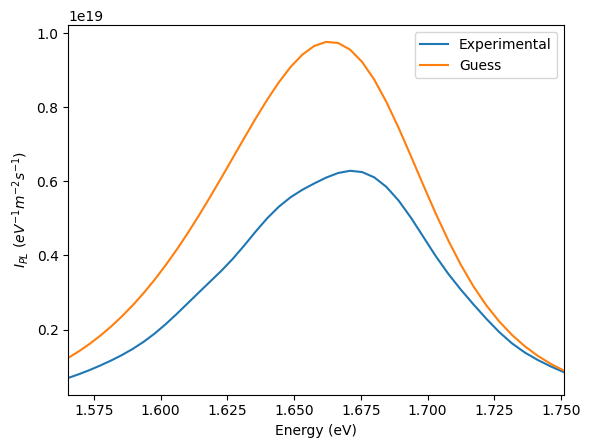

In [5]:
fig, ax = plt.subplots()
ax.plot(exp_energy_crop, np.mean(exp_pl_crop, axis=(1, 2)), label='Experimental')
ax.plot(exp_energy_crop, genplanck.gen_planck(exp_energy_crop, guesses[0], guesses[1], guesses[2], guesses[3]), label='Guess')
ax.set(xlabel='Energy (eV)', ylabel='$I_{PL}\ (eV^{-1}m^{-2}s^{-1})$', xlim=[np.min(exp_energy_crop), np.max(exp_energy_crop)])
ax.legend()
plt.show()

In [6]:
result, info = genplanck.fit_qfls(exp_energy_crop, exp_pl_crop, guesses=guesses, batch_size=2048, max_iterations=10, step_size=0.75, verbose=False)

100%|██████████| 512/512 [03:33<00:00,  2.39it/s]


In [13]:
with h5py.File(file_path, 'a') as f:
    if 'result' in list(f.keys()):
        del f['result']
    f.create_group('result')
    for key in result.keys():
        f['result'][key] = result[key]

In [ ]:
fig, ax = plt.subplots()
visualization.imshow(ax, result['qfls'], vmin=np.nanpercentile(result['qfls'], 1), vmax=np.nanpercentile(result['qfls'], 99), cbar_label='QFLS (eV)')
plt.show()